# 3rd practice: Neural Networks
* **Course**: Artificial Intelligence
* **University**: Universitat Rovira i Virgili

In this practice students will explore the following fundamentals of machine learning:
* Data analysis
* Preprocessing
* Basic desgin of Multi-Layer Perceptrons (MLP)
* Training of neural networks
* Results analysis
* Decision making / Critical thinking

While reading this notebook, please note the following information:
* Each section (and subsection) has a title and a brief description of its contents.
* If a section (or subsection) title starts with `Student`, the student has work to do inside it, adding code and/or text.
* If the title of a section begins with `Teacher`, all its content (including subsections) is part of the work statement. Subsequently, it **MUST NOT** be modified.
* Sections must be executed in order.
* **<font color='lightgreen'>Please enter your full name in the next cell in this section BEFORE going any further.</font>**

## External resources
Please, read the following tutorials to get an introduction to Google Colab and the Pandas library:
* https://colab.research.google.com/notebooks/basic_features_overview.ipynb
* https://colab.research.google.com/notebooks/mlcc/intro_to_pandas.ipynb

## Deliverable
It is an **individual** practice. The student only needs to deliver **this notebook** including the answers. The file must have as name `P3_[Name]_[Surname/s].ipynb`, replacing `[Name]` and `[Surname/s]` with those from the student.

## Evaluation
To be accepted, all practices delivered must contain at least one solution with a preprocessing step and one solution with a modified neural network.
A third solution with a second preprocessing step will be valued.

<font color='orange'>**Similar or identical practices will get a grade of 0.**</font>

In [23]:
STUDENT_NAME = "Angelina Ruiz Jimenez" # @param {type:"string"}

# Teacher: Initialization
Defines the **Imports** and **Device** for the practice. More details in each subsection.

## Imports
The following code cell determines the available packages/libraries.

**You CANNOT add any other import, neither here nor anywhere else in the code.**

In [55]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Device
Checks if there is a GPU for training the neural networks. If not, the CPU will be used. It is recommended to first test if the preprocessing and model definition are correct in a CPU-based environment and then switch to the GPU-based environment for training.

In [56]:
if torch.cuda.is_available():
  DEVICE = "cuda"
  print("There is GPU available. Printing GPU information:")
  !nvidia-smi
else:
  DEVICE = "cpu"
  print("There is no GPU available, using CPU.")

There is no GPU available, using CPU.


# Teacher: Base code
<a name="base_code"></a>

Code available for use in the `Student` sections.

## Data loading
This loads the `CarsData.csv` file (available in Moodle) as a Pandas dataframe. **The file must first be loaded into the environment folder** 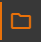.

This dataset will be used for the **Manufacturer classification task**, where the machine learning model aims to predict/output the Manufacturer of a car using the rest of features as inputs.

The dataset was extracted from [this website](https://www.kaggle.com/datasets/meruvulikith/90000-cars-data-from-1970-to-2024/data). The dataframe to be used in practice is a 25% subsample of the full dataset, different from that of other students.

In [57]:
LABEL_COL_NAME = "Manufacturer" # Global constant

def data_loading(file_name):
  original_df = pd.read_csv(file_name)
  original_df = original_df.drop(columns=["model"]) # Model column is not available
  original_df

  # Infer column types
  infer_type = lambda x: x if pd.api.types.is_numeric_dtype(x) else pd.Categorical(x)
  original_df = original_df.apply(infer_type, axis=0)

  # Select subset
  frac=0.25
  random_seed = hash(STUDENT_NAME) % (2**32 -1) # Seed must be between 0 and 2**32 - 1
  df = original_df.sample(frac=frac, random_state=random_seed).reset_index()
  df = df.drop(columns=["index"])

  return df

## Analysis
Functions that facilitate the data distribution analysis for the [Student: Exploratory data analysis](#data_analysis) section.

In [68]:
def feature_histogram(df, column_name):
    column_data = df[column_name]

    if pd.api.types.is_numeric_dtype(column_data):
        plt.hist(column_data, bins=10)
    else:
        value_counts = column_data.value_counts()
        value_counts.plot(kind='bar')

    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(column_name))
    plt.show()


def feature_stats(df, column_name, verbose=True):
  stats = {}
  column_data = df[column_name]

  # Numerical
  if pd.api.types.is_numeric_dtype(column_data):
    stats["Min"] = column_data.min()
    stats["Max"] = column_data.max()
    stats["Mean"] = column_data.mean()
    stats["Std"] = column_data.std()

  # Categorical
  if pd.api.types.is_categorical_dtype(column_data):
    stats["Unique"] = column_data.unique()

  if verbose and len(stats) > 0:
    stats_str = ""
    for name, value in stats.items():
      stats_str += f" {name}={value} |"
    print(f"Stats of {column_name}:{stats_str}")

  return stats


def features_relationship(df, column_name_1, column_name_2):
    data1 = df[column_name_1]
    data2 = df[column_name_2]

    # Both columns are numerical
    if pd.api.types.is_numeric_dtype(data1) and pd.api.types.is_numeric_dtype(data2):
        plt.scatter(data1, data2)
        plt.xlabel(column_name_1)
        plt.ylabel(column_name_2)
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # Both columns are categorical
    elif pd.api.types.is_categorical_dtype(data1) and pd.api.types.is_categorical_dtype(data2):
        cross_table = pd.crosstab(data1, data2)
        cross_table.plot(kind='bar', stacked=True)
        plt.xlabel(column_name_1)
        plt.ylabel('Frequency')
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # A column is numerical and the other categorical
    else:
        # Check which is which
        if pd.api.types.is_categorical_dtype(data1):
            categorical_column = column_name_1
            numerical_column = column_name_2
        else:
            categorical_column = column_name_2
            numerical_column = column_name_1

        # Get data
        categorical_data = df[categorical_column]
        numerical_data = df[numerical_column]

        # Convert categorical data to numeric representation
        categorical_codes = categorical_data.astype('category').cat.codes

        # Plot
        plt.scatter(numerical_data, categorical_codes)
        plt.xlabel(numerical_column)
        plt.ylabel(categorical_column)
        plt.title('Relationship between {} and {}'.format(numerical_column, categorical_column))
        plt.yticks(ticks=categorical_codes.unique(), labels=categorical_data.unique()) # Set yticks labels as category names
        plt.show()

## PyTorch dataset
Function that transforms the preprocessed dataframe into the training and test datasets using the PyTorch TensorDataset class. To be used in the [Experiments](#experiments) section.

In [59]:
def df_to_dataset(preprocessed_df, label_col_name=LABEL_COL_NAME):
  if not label_col_name in preprocessed_df.columns:
    raise Exception(f"Dataframe does not contain the label column [{label_col_name}]")

  # Obtain inputs and labels
  columns_to_discard = [col_name for col_name in preprocessed_df.columns if col_name == label_col_name]
  x = preprocessed_df.drop(columns=columns_to_discard)
  y = preprocessed_df[label_col_name]

  # Encode labels (string to identifier integer)
  label_encoder = LabelEncoder()
  y = label_encoder.fit_transform(y)

  # Convert data to PyTorch tensors
  x_tensor = torch.tensor(x.values, dtype=torch.float)
  y_tensor = torch.tensor(y, dtype=torch.long)

  # Train-test split
  x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42, shuffle=True)

  # Create PyTorch datasets
  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

  # Get additional info for the model
  input_size = x_train_tensor.shape[1]
  num_classes = len(label_encoder.classes_)

  return train_dataset, test_dataset, input_size, num_classes, label_encoder

## Model
Basic function for the model creation and its movement to the corresponding DEVICE (GPU or CPU). To be used in the [Experiments](#experiments) section.

In [60]:
def create_model(model_class, input_size, num_classes, verbose=True):
  model = model_class(input_size, num_classes)
  model.to(DEVICE)

  if verbose:
    num_parameters = 0
    for layer in model.parameters():
      num_parameters += layer.nelement() * layer.element_size()
    print(f"The model has {num_parameters} parameters")

  return model

## Training
Function that trains a **model** with a **dataset**, for a **number of epochs** and using a specific **learning rate (lr)**. To be used in the [Experiments](#experiments) section.

In [61]:
def train(model, dataset, num_epochs, lr, batch_size=32):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create PyTorch dataloader
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Set up loss evolution plot
    losses = []
    plt.ion()
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Evolution')
    line, = ax.plot([], [])

    # Training loop
    for epoch in range(num_epochs):
        # Set model to train mode
        model.train()

        epoch_loss = 0.0
        num_batches = 0

        for inputs, targets in train_loader:
            # Move data to GPU
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update epoch loss
            epoch_loss += loss.item()
            num_batches += 1

        # Update lists for loss plotting
        mean_epoch_loss = epoch_loss / num_batches
        losses.append(mean_epoch_loss)

        # Update plot
        line.set_ydata(losses)
        line.set_xdata(range(1, len(losses)+1))
        ax.relim()
        ax.autoscale_view()
        display.clear_output(wait=True)
        display.display(plt.gcf())

        # Print specific epoch info
        print(f'Epoch [{epoch+1}/{num_epochs}] | Mean epoch loss: {mean_epoch_loss:.4f}')

    # Turn off interactive mode and show plot
    plt.ioff()
    plt.close()

    return losses

## Evaluation
Functions for the result analysis of the [Experiments](#experiments) section. In particular, for the analysis of [classification accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy?hl=es-419) and [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).


In [62]:
def evaluate(model, dataset, batch_size=256):
  # Create dataloader
  eval_loader = DataLoader(dataset, batch_size, shuffle=False)

  model.eval()  # Set model to evaluation mode
  with torch.no_grad():
      correct = 0
      total = 0
      all_targets = np.empty(len(dataset), dtype=int)
      all_predicted = np.empty_like(all_targets)
      for inputs, targets in eval_loader:
          # Move data to GPU
          inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

          # Forward pass
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)

          # Store targets and predicted labels
          all_targets[total:total+targets.size(0)] = targets.cpu().numpy()
          all_predicted[total:total+targets.size(0)] = predicted.cpu().numpy()

          # Update total and correct predictions
          total += targets.size(0)
          correct += (predicted == targets).sum().item()

      accuracy = correct / total

  return accuracy, all_targets, all_predicted


def plot_confusion_matrix(all_targets, all_predicted, label_encoder):
  # Calculate confusion matrix
  cm = confusion_matrix(all_targets, all_predicted)

  # Plot confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

# Student: Exploratory data analysis
<a name="data_analysis"></a>

In this section, the student will have to perform the following tasks:
* Load the dataset.
* Analyze each feature's data distribution using plots and textual explanations of these plots.
* Analyze relevant relationships between pairs of features' data distributions with plots and textual explanations of these plots. Focus only on the important pairs to avoid overwhelming combinations.

In [63]:
df = data_loading("CarsData.csv")
df

,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer
0,2019,15990,Manual,4180,Petrol,145,44.1,1.0,hyundi
1,2019,33972,Semi-Auto,4809,Diesel,145,54.3,2.0,BMW
2,2019,24000,Automatic,14391,Petrol,150,44.1,1.5,Audi
3,2019,35295,Semi-Auto,3249,Petrol,145,32.1,2.0,Audi
4,2019,15460,Manual,6810,Petrol,145,60.1,1.0,ford
...,...,...,...,...,...,...,...,...,...
24423,2019,17998,Manual,10,Petrol,145,54.3,1.2,vauxhall
24424,2019,14176,Manual,5630,Petrol,145,47.9,1.0,volkswagen
24425,2017,6991,Manual,15969,Petrol,125,54.3,1.2,ford
24426,2019,12500,Manual,1987,Petrol,145,47.9,1.5,toyota


Diferentes pruebas de visualización del dataset

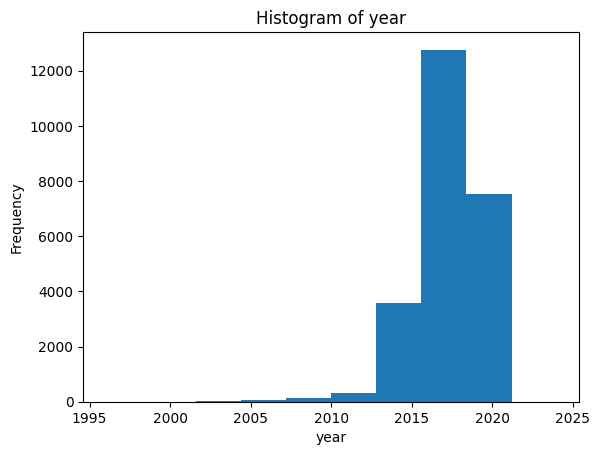

In [64]:
feature_histogram(df,"year")


In [65]:
feature_stats(df, "year")


Stats of year: Min=1996 | Max=2024 | Mean=2017.0717619125594 | Std=2.095805789281463 |


{'Min': 1996,
 'Max': 2024,
 'Mean': 2017.0717619125594,
 'Std': 2.095805789281463}

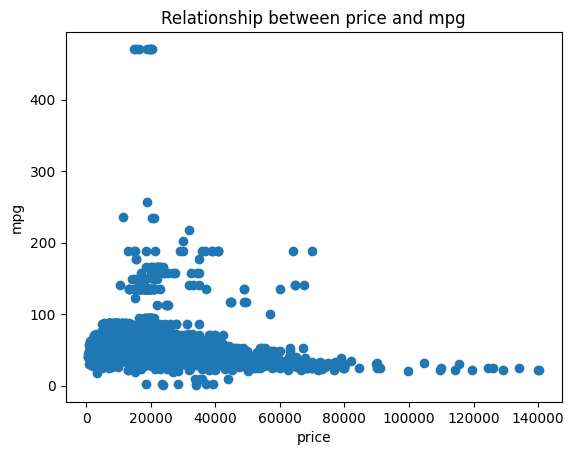

In [66]:
features_relationship(df, "price", "mpg")

# Teacher: Baseline solution
<a name="baseline"></a>
This defines the most basic (and unsuccessful) ready-to-use solution for the **Manufacturer classification task**. It includes the main components:
* Preprocessing
* Model
* Training
* Evaluation

Nonetheless, there are a lot of important things missing, as can be seen from the very poor results. Use this as inspiration for your [Solution 1A](#solution_1a), that **must** be better than this.

## Preprocessing

In [36]:
def preprocessing_0(df):
  preprocessed_df = df.copy()

  # Define columns to use and categorical
  categorical_cols = ["transmission", "fuelType"]
  columns_to_use = ["year", "price", "mileage", "tax", "mpg", "engineSize"] + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  # Column transformer of the features
  column_transformer = ColumnTransformer([('onehot', OneHotEncoder(), categorical_cols)],
                                         remainder='passthrough')
  preprocessed_df = pd.DataFrame(column_transformer.fit_transform(preprocessed_df))
  # IMPORTANT: Student's can't use ColumnTransformer or similars, only Pandas functions

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

preprocessed_df = preprocessing_0(df)
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

## Model

In [37]:
class Model_0(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model_0, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, num_classes),
            nn.Softmax(dim=1) # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)

model = create_model(Model_0, input_size, num_classes)

The model has 576 parameters


## Training

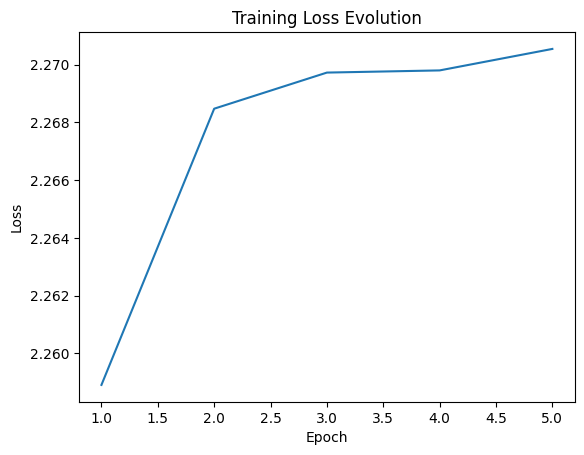

Epoch [5/5] | Mean epoch loss: 2.2705
CPU times: user 6.31 s, sys: 386 ms, total: 6.7 s
Wall time: 7.31 s


In [38]:
%%time
losses = train(model, train_dataset, num_epochs=5, lr=0.001)
#función train se encarga de entrenar el modelo, el número de epocas es 5 (veces que el modelo hace un entranamiento
#completo) y lr es la tasa de aprendizaje, osea la velocidad con la que se hace el entrenamiento

## Evaluation

Train accuracy: 44.18%
Test accuracy: 43.68%


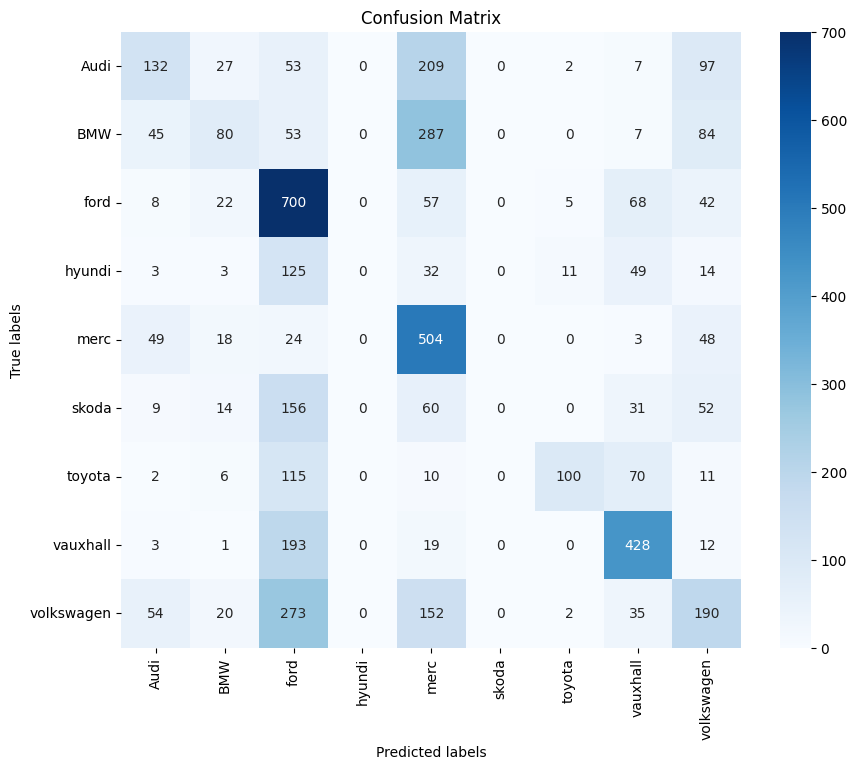

In [67]:
train_accuracy, _, _ = evaluate(model, train_dataset)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

# Student: Experiments
<a name="experiments"></a>

In this section, the student will have to create two or three consequent solutions for the **Manufacturer classification task**. Each solution must contain the following components:
* **Idea**: What is the target/reasoning of the solution (e.g., I observed that the previous model had a very reduced size and I want to explore the effects of using a bigger model).
* **Preprocessing**: Prepare the desired features of the dataframe `df` for the neural network. To this end, students can **only use Pandas'** functions.
* **Model**: Definition of the Multi-Layer Perceptron model, **only** using [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers and
 [activations from this list](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).
* **Training**: Perform the learning process trying to maximize the results.
* **Evaluation**: Measuring the performance of the trained model.
* **Results analysis**: Examination of the evaluation, focusing in:
  * Accuracy
  * Confusion matrix
  * Training time

It can be seen that these are the same as for the baseline solution, but adding the **Idea** and **Results analysis** components. An extended analysis of the baseline results will also be requested.

None of the solutions has to be the best/ideal, but all of them must be better than the [baseline](#baseline). The idea is to present consequent solutions, being each one the coherent next step of the previous one (the previous step of [Solution 1A](#solution_1a) is the [baseline](#baseline)). This does not imply that each solution has to improve the results of the previous one, but to modify at least one of the components (i.e., preprocessing or model) in a significant and coherent way.

In particular, we aim for the first two solutions ([Solution 1A](#solution_1a) and [Solution 1B](#solution_1b)) to emphasize preprocessing. Specifically, both will utilize the same basic MLP model but experiment with two distinct preprocessing approaches. An explicit comparison of these preprocessing methods and their respective outcomes is necessary. For [Solution 2](#solution_2), the preprocessing method from one of the earlier solutions will be employed. The goal of this final solution is to enhance results by refining the MLP model.

## Analysis of baseline
Provide a comprehensive analysis of the [baseline solution](#baseline). Apart from the results (i.e., accuracy, confusion matrix and runtime), a review of the solution design (i.e., **preprocessing, model an training**) is also required. It is not necessary to explain or analysis the code, but the choices. For instace, which features are used and how.

**Analisis de la solución base**
El resultado de la primera solución proporcionada por el profesor, podemos observar que la precisión



Si nos centramos en el código, a rasgos generales, la primera solucón que proporciona el profesor, tarta el preprocessamiento usando funciones ColumnTransfer y OneHotEncoder

## Common functions
For avoiding code repetition along all the solutions, you can use this subsection for your common functions and/or classes.

In [40]:
def standardization(col):
    media = col.mean()
    std = col.std()
    standarizada = (col - media) / std
    return standarizada


## Solution 1A: First preprocessing
<a name="solution_1a"></a>

Subsequent of [Baseline](#baseline), it implements a basic MLP (better than the provided at the baseline) and a first option for the preprocessing step.

In [69]:
def preprocessing_1A(df):
  preprocessed_df = df.copy()

  # Define columns to use and categorical
  categorical_cols = ["transmission", "fuelType"]
  numerical_cols = ["year", "price", "mileage", "tax", "mpg", "engineSize"]
  #columns_to_use = ["year", "price", "mileage", "tax", "mpg", "engineSize"] + categorical_cols
  columns_to_use = numerical_cols + categorical_cols


  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  #Para cada columna categorica se genera una columna binaria
  for old_col in categorical_cols:
    #get_dummies realiza la codificación one_hot
    one_hot_encoding_df = pd.get_dummies(preprocessed_df[old_col])*1

    #agregar las nuevas columnas binarias
    for new_col in one_hot_encoding_df:
        preprocessed_df[new_col] = one_hot_encoding_df[new_col]

    #delete the old categorical column
    del preprocessed_df[old_col]

 #Normalizar columnas numericas,  (valor-min/(max-min))
  for col in numerical_cols:
    preprocessed_df[col] = (preprocessed_df[col] - preprocessed_df[col].min())/ (preprocessed_df[col].max() - preprocessed_df[col].min())


  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

preprocessed_df = preprocessing_1A(df)  #aplicar la funcion de preprocessamiento
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

In [42]:
preprocessed_df #llamar al dataset para ver una pequeña muestra

,year,price,mileage,tax,mpg,engineSize,Automatic,Manual,Other,Semi-Auto,Diesel,Electric,Hybrid,Petrol,Manufacturer
0,0.821429,0.109831,0.014979,0.250000,0.091548,0.161290,0,1,0,0,0,0,0,1,hyundi
1,0.821429,0.238578,0.017233,0.250000,0.113264,0.322581,0,0,0,1,1,0,0,0,BMW
2,0.821429,0.167181,0.051577,0.258621,0.091548,0.241935,1,0,0,0,0,0,0,1,Audi
3,0.821429,0.248051,0.011642,0.250000,0.066000,0.322581,0,0,0,1,0,0,0,1,Audi
4,0.821429,0.106036,0.024405,0.250000,0.125612,0.161290,0,1,0,0,0,0,0,1,ford
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24423,0.821429,0.124208,0.000032,0.250000,0.113264,0.193548,0,1,0,0,0,0,0,1,vauxhall
24424,0.821429,0.096843,0.020176,0.250000,0.099638,0.161290,0,1,0,0,0,0,0,1,volkswagen
24425,0.750000,0.045400,0.057233,0.215517,0.113264,0.193548,0,1,0,0,0,0,0,1,ford
24426,0.821429,0.084843,0.007118,0.250000,0.099638,0.241935,0,1,0,0,0,0,0,1,toyota


In [44]:
class Model_1A(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model_1A, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 32), #4 num de neuronas, osea metes 14 inputs en 4 neuronas
            nn.ReLU(), #función de activación
            nn.Linear(32, 64), #4 porque necesito 4 inputs por cada neurona
            nn.ReLU(),
            nn.Linear(64, num_classes), #tendremos 9 de salida
            nn.Softmax(dim=1) # Mandatory activation to normalize probabilities between 0 and 1
        )
      #faltaba la activación de cada capa.
    def forward(self, x):
        return self.layers(x)

model = create_model(Model_1A, input_size, num_classes)

The model has 12708 parameters


Ativacion de cada capa,
si no hubiesemos puesto esta activación entre capa y capa seria como solo tener una capa y no múltiples.
La activación que vamos a usar es muy sencilla, RELU.
Es rápida,
No hay ninguna garantia que una vaya a ir mejor que otra.

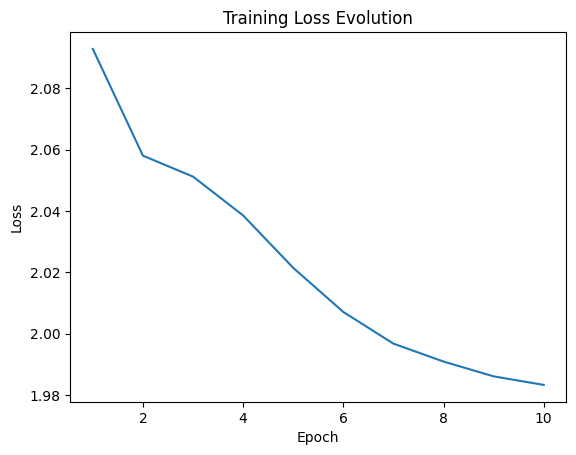

Epoch [10/10] | Mean epoch loss: 1.9833
CPU times: user 12.2 s, sys: 212 ms, total: 12.4 s
Wall time: 12.5 s


In [45]:
%%time
losses = train(model, train_dataset, num_epochs=10, lr = 0.001)
#función train se encarga de entrenar el modelo, el número de epocas es 5 (veces que el modelo hace un entranamiento
#completo) y lr es la tasa de aprendizaje, osea la velocidad con la que se hace el entrenamiento

Train accuracy: 38.44%
Test accuracy: 38.68%


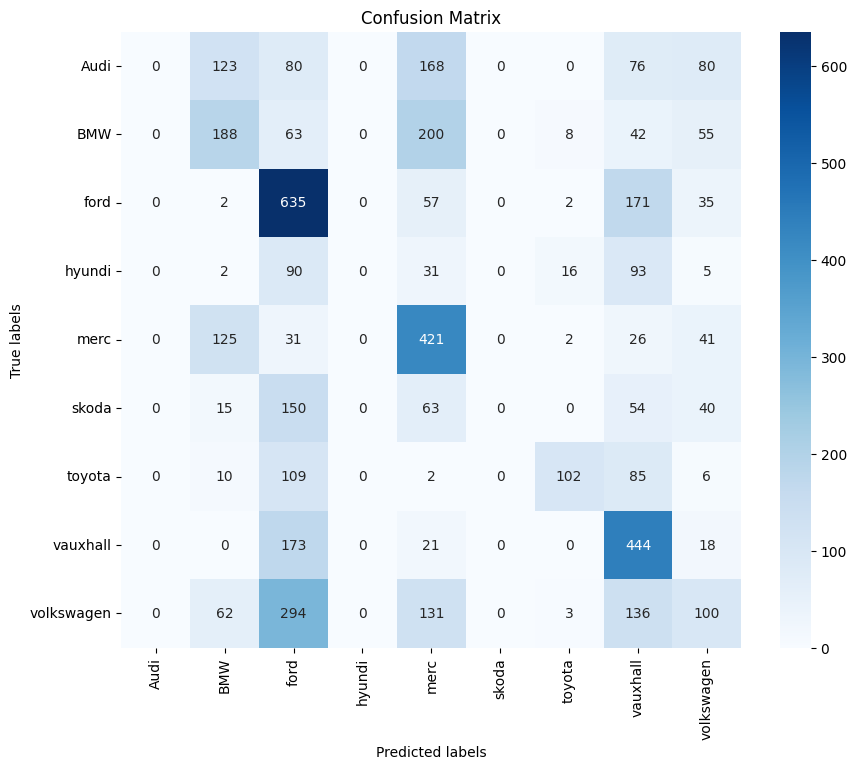

In [46]:
train_accuracy, _, _ = evaluate(model, train_dataset)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

## Solution 1B: Second preprocessing solution
<a name="solution_1b"></a>

Subsequent of the [Solution 1A](#solution_1a), uses the same basic MLP but with an alternative preprocessing step.

In [47]:
def preprocessing_1B(df):
  preprocessed_df = df.copy()

  # Define columns to use and categorical
  categorical_cols = ["transmission", "fuelType"]
  numerical_cols = ["year", "price", "mileage", "tax", "mpg", "engineSize"]

  columns_to_use = numerical_cols + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  #Para cada columna categorica se genera una columna binaria
  for old_col in categorical_cols:
    #get_dummies realiza la codificación one_hot
    one_hot_encoding_df = pd.get_dummies(preprocessed_df[old_col])*1

    #agregar las nuevas columnas binarias
    for new_col in one_hot_encoding_df:
        preprocessed_df[new_col] = one_hot_encoding_df[new_col]

    #delete the old categorical column
    del preprocessed_df[old_col]

 #Normalizar columnas numericas,  (valor-min/(max-min))
  for col in numerical_cols:
    colAux = preprocessed_df[col]
    columnaStand = standardization(colAux)
    df[col] = columnaStand

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

preprocessed_df = preprocessing_1B(df)  #aplicar la funcion de preprocessamiento
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

## Solution 2: New model solution
<a name="solution_2"></a>

Subsequent of either [Solution 1A](#solution_1a) or [Solution 1B](#solution_1b), uses the same preprocessing step but improves the MLP model.

In [70]:
preprocessed_df = preprocessing_1A(df)
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

In [49]:
class Model_2(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=128): # Hidden size es anchura (por lo general potencias de 2) y P cantidad de capas
        super(Model_2, self).__init__()
        self.layers = nn.Sequential(
            # Podemos hacerlo iterando sobre un bucle el comando de linear sin contar el input, luego al final añades el output y luego añadir
            # self.layers = nn.Sequential(*layer) con un puntero porque sino no funciona
            nn.Linear(input_size, hidden_size), #32 neuronas (salida)
            nn.ReLU(), # función de activación
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
            nn.Softmax(dim=1) # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)

model = create_model(Model_2, input_size, num_classes)

The model has 210468 parameters


En este modelo, definimos como hidden size de 128, con lo que siempre va a ser como input y como output el mismo
Otro ejemplo complicado que se utiliza en encoder , en la que recibe muchos inputs lo tranforma en una primera parte en un vector con lo que obtenemos un codigo facil de comparar y en una segunda la vuelve a poner como la misma cantidad de outputs con lo que conseguimos que este vector sea muy facil de comparar con los otros del dataset.
Este modelo para clasificar no es recomendable porque generamos un cuello de botella.

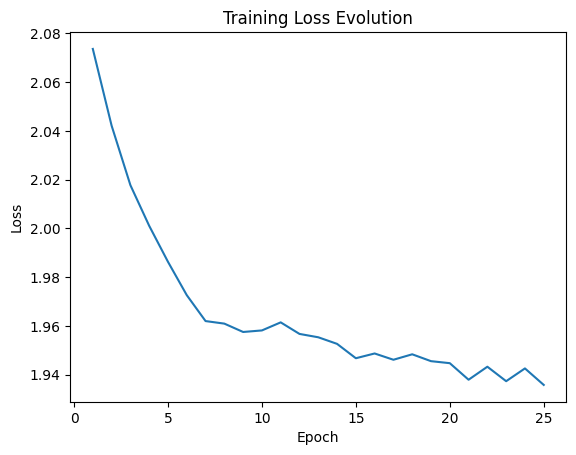

Epoch [25/25] | Mean epoch loss: 1.9358
CPU times: user 54.5 s, sys: 448 ms, total: 55 s
Wall time: 56.1 s


In [50]:
%%time
losses = train(model, train_dataset, num_epochs=25, lr = 0.001)

Train accuracy: 44.18%
Test accuracy: 43.68%


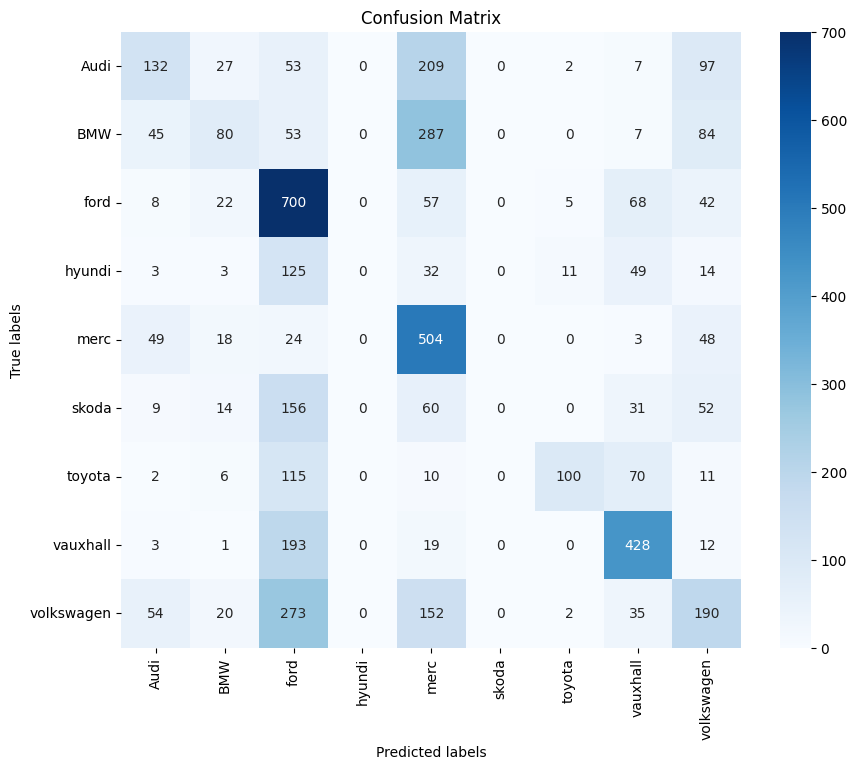

In [51]:
train_accuracy, _, _ = evaluate(model, train_dataset)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

Si los datos de los que estamos aprendiendo estan sesgados pese a que el train accuracy sea un 98% esatria mal.
Ejemplo gato con pelota

Si el train Acc = 98% y el Test acc 94%, appropiate- fitting
Si el train Acc = 100% y el Test acc 60%, solo esta memorizando, over-fitting
Si el train Acc = 11% y el Test acc 11%, underfitting
Si el train Acc = 70% y el Test acc 65%,  overfitting pero sospechariamos direcatemente
Minimizar el loss entre ambos, pero nos basamos en el test acc

incremento

*   Lr (mida de passos)-> Fastest- training
      Si los pasos son muy grandes es dificil de llegar a un mínimo local, con lo que en ningun momento llega al minimo.
*   #Epochs -> puede llegar a overfittig, more training time

decremento

*   LR (cantidad de pasos)-> Slower training, better loss (except small local minim)).   Posibilidad de quedarse atascado''
*   #Epochs -> under-fitting, less training time


A modelos grandes, lr mas bajos


## Conceptos clave para desarollar la practica

**One hot enconding** -> Es una forma de transformar los valores no númericos para que el modelo sea capaz de reconocer. Por cada valor de la columna, crea una columna binaria

**Softmax**-> Recibe las activaciones de la última capa y normaliza entre max y min. Devolviendo probabilidades (la suma de todas las probabilidades debe de ser 1).

**Normalizar col**-> Para que todos los valores esten en una escala del 0 al 1. En este caso se usa (valor-min/(max-min))

 **df_to_dataset** -> Convierte el DataFrame preprocesado en conjuntos de datos de entrenamiento y prueba (train_dataset y test_dataset, y obtiene el tamaño de entrada (input_size), el número de clases (num_classes) y un codificador de etiquetas (label_encoder).

 !!!Nunca se deben estandarizar las variables después de ser binarizadas

**INPUT LAYER** -> Obligatoriamente, a cada neurona le entre el mismo número de columnas.

**Hidden Layers** -> Necesariamente, la canitdad de valores tiene que ser la cantidad e valores de la capa anterior. Ponemos tantas hidden layers como consideremos

**OUTPUT Layer** -> La cantidad de conexiones tiene que ser la cantidad de neuronas que salida

**Activación entre capas**
Si que en base a analisis, hay un cierto número Cantidad de neuronas de cada etapa, cantidad de conceptos/caracteristicas permite procesar cada etapa -> **Anchura **

Cantidad de hidden layers, el número de complejidad de detección de patrones. ->** Profundiad **

*El input y output no lo consideramos por que no esta en nuestro control*

**Modelo bert** -> La manera mas experimental, es definiendo un bloque, que es un cachito de red neuronal, con una profundidad y una anchura fija. Es decir, definimos una subred neuronal que va a tener como profundiad p y una anchura a. Por tanto el número de entrada y salida siempre es el mismo, y en estos modelos lo que cambiamos es la anchura, pero la profundiad siempre es fija.
